## TIME BASED ANALYSIS

## DOES QUANTITIES OF PRODUCTS INFLUENCE THE TIME TAKEN TO GET THE PRODUCTS DELIVER TO THE CUSTOMERS?


# periods taken to get the products deliver to the customers

Waiting_period: The difference between the shipped_date and the order_date

required_time: The is the time taken to get the products delivered to the customers. this was gotten by finding the difference between required_date from the shipped_date

In [1]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pycountry
import psycopg2
import pandas as pd
import numpy as np
import psycopg2.extras
import pandas._testing as tm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro
from numpy.random import randn

In [3]:
sns.set_style('darkgrid')
plt.rcParams['font.size'] = 15
plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['figure.facecolor'] = '#FFE5B4'

In [4]:
con = psycopg2.connect(database="northwind",
               
                       user ='postgres',
                      password='olaronke',
                      host = '127.0.0.1',
                      port = '5432')

In [5]:
##connecting to the cursor object
cur = con.cursor(cursor_factory= psycopg2.extras.DictCursor)

In [6]:
## customer purchase details
cur.execute("""SELECT customers.customer_id, customers.country, date_part('days', age(orders.shipped_date::date, orders.order_date::date)) AS waiting_period, 
date_part('days', age(orders.required_date::date, orders.shipped_date::date)) AS required_time
from orders
JOIN customers ON customers.customer_id = orders.customer_id
JOIN order_details ON order_details.order_id = orders.order_id""")




sales_details= pd.DataFrame(cur.fetchall(), columns=["customer_id", "country","waiting_period","required_time"])


In [7]:
sales_details.isnull().sum()

customer_id        0
country            0
waiting_period    73
required_time     73
dtype: int64

In [8]:
cur.execute("""SELECT customers.customer_id, customers.country, round(avg(order_details.unit_price))as price_per_quantity, products.product_name, sum(order_details.quantity) as Quantities, sum(order_details.quantity*order_details.unit_price) as purchase_price
FROM order_details
JOIN orders 
ON orders.order_id = order_details.order_id
JOIN customers 
ON customers.customer_id = orders.customer_id
JOIN products 
ON products.product_id = order_details.product_id
group by customers.country, products.product_name,customers.customer_id

order by Quantities """)

df1= pd.DataFrame(cur.fetchall(), columns=["customer_id", "country","price_per_quantity", "product_name", "Quantities", "purchase_price"])

In [9]:
df1.isnull().sum()

customer_id           0
country               0
price_per_quantity    0
product_name          0
Quantities            0
purchase_price        0
dtype: int64

In [10]:
cur.execute("""SELECT
    to_char(order_date, 'Day') AS Day_Of_Week,
    to_char(order_date, 'Month') AS Months,
    to_char(order_date, 'YYYY') AS Year,
    customer_id
FROM
    orders
GROUP BY
    customer_id, to_char(order_date, 'Day'), to_char(order_date, 'Month'), to_char(order_date, 'YYYY')
""")

Days_Months = pd.DataFrame(cur.fetchall(), columns=["Day_Of_Week", "Months", "Year", "customer_id"])


In [11]:
Days_Months.isnull().sum()

Day_Of_Week    0
Months         0
Year           0
customer_id    0
dtype: int64

In [12]:
# merging df1 and days_months dataframe togethher
CA = pd.merge(Days_Months,df1, on='customer_id', how='outer')

In [13]:
CA.isnull().sum()

Day_Of_Week           0
Months                0
Year                  0
customer_id           0
country               0
price_per_quantity    0
product_name          0
Quantities            0
purchase_price        0
dtype: int64

In [14]:
Final_CA = pd.merge(CA,sales_details, on='customer_id', how='outer')

In [15]:
Final_CA.isnull().sum()

Day_Of_Week               0
Months                    0
Year                      0
customer_id               0
country_x                 0
price_per_quantity        0
product_name              0
Quantities                0
purchase_price            0
country_y                 0
waiting_period        40727
required_time         40727
dtype: int64

In [16]:
CLUSTER_DF = Final_CA.dropna()

In [17]:
CLUSTER_DF.isnull().sum()

Day_Of_Week           0
Months                0
Year                  0
customer_id           0
country_x             0
price_per_quantity    0
product_name          0
Quantities            0
purchase_price        0
country_y             0
waiting_period        0
required_time         0
dtype: int64

In [18]:
CLUSTER_DF = CLUSTER_DF.drop('country_y', axis =1)

In [19]:
CLUSTER_DF.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 905664 entries, 0 to 946390
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Day_Of_Week         905664 non-null  object 
 1   Months              905664 non-null  object 
 2   Year                905664 non-null  object 
 3   customer_id         905664 non-null  object 
 4   country_x           905664 non-null  object 
 5   price_per_quantity  905664 non-null  float64
 6   product_name        905664 non-null  object 
 7   Quantities          905664 non-null  int64  
 8   purchase_price      905664 non-null  float64
 9   waiting_period      905664 non-null  float64
 10  required_time       905664 non-null  float64
dtypes: float64(4), int64(1), object(6)
memory usage: 82.9+ MB


In [20]:
## change of data type
columns_to_convert = ['Day_Of_Week', 'Months', 'customer_id', 'country_x', 'product_name']

In [21]:
CLUSTER_DF[columns_to_convert] = CLUSTER_DF[columns_to_convert].astype('category')


In [22]:
CLUSTER_DF.describe()

,price_per_quantity,Quantities,purchase_price,waiting_period,required_time
count,905664.000000,905664.000000,905664.000000,905664.000000,905664.000000
mean,26.738117,55.614393,1444.998353,7.841852,17.419165
std,29.962035,48.792174,2180.129530,5.821859,8.888979
min,2.000000,1.000000,4.800000,0.000000,-23.000000
25%,12.000000,20.000000,344.000015,4.000000,13.000000
50%,19.000000,40.000000,746.999989,7.000000,21.000000
75%,32.000000,75.000000,1700.000000,9.000000,24.000000
max,264.000000,248.000000,23715.000000,30.000000,30.000000


In [23]:
CLUSTER_DF.head()

,Day_Of_Week,Months,Year,customer_id,country_x,price_per_quantity,product_name,Quantities,purchase_price,waiting_period,required_time
0,Monday,April,1998,HANAR,Brazil,22.0,Flotemysost,9,193.5,4.0,24.0
1,Monday,April,1998,HANAR,Brazil,22.0,Flotemysost,9,193.5,4.0,24.0
2,Monday,April,1998,HANAR,Brazil,22.0,Flotemysost,9,193.5,4.0,24.0
3,Monday,April,1998,HANAR,Brazil,22.0,Flotemysost,9,193.5,6.0,8.0
4,Monday,April,1998,HANAR,Brazil,22.0,Flotemysost,9,193.5,6.0,8.0


In [24]:
# Calculate average purchase price per month
average_price_per_month = CLUSTER_DF.groupby("Months")["purchase_price"].mean()
average_price_per_month

Months
April        1504.511676
August       1388.906923
December     1492.128854
February     1431.436695
January      1412.460804
July         1543.277552
June         1332.395518
March        1328.041461
May          1343.423141
November     1452.787652
October      1550.588875
September    1456.183719
Name: purchase_price, dtype: float64

C:\Users\user\AppData\Local\Temp\ipykernel_7712\3239269527.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[0].set_xticklabels(xlabels, rotation=45, ha = 'right')
C:\Users\user\AppData\Local\Temp\ipykernel_7712\3239269527.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  axes[1].set_xticklabels(xlabels, rotation=45, ha = 'right')


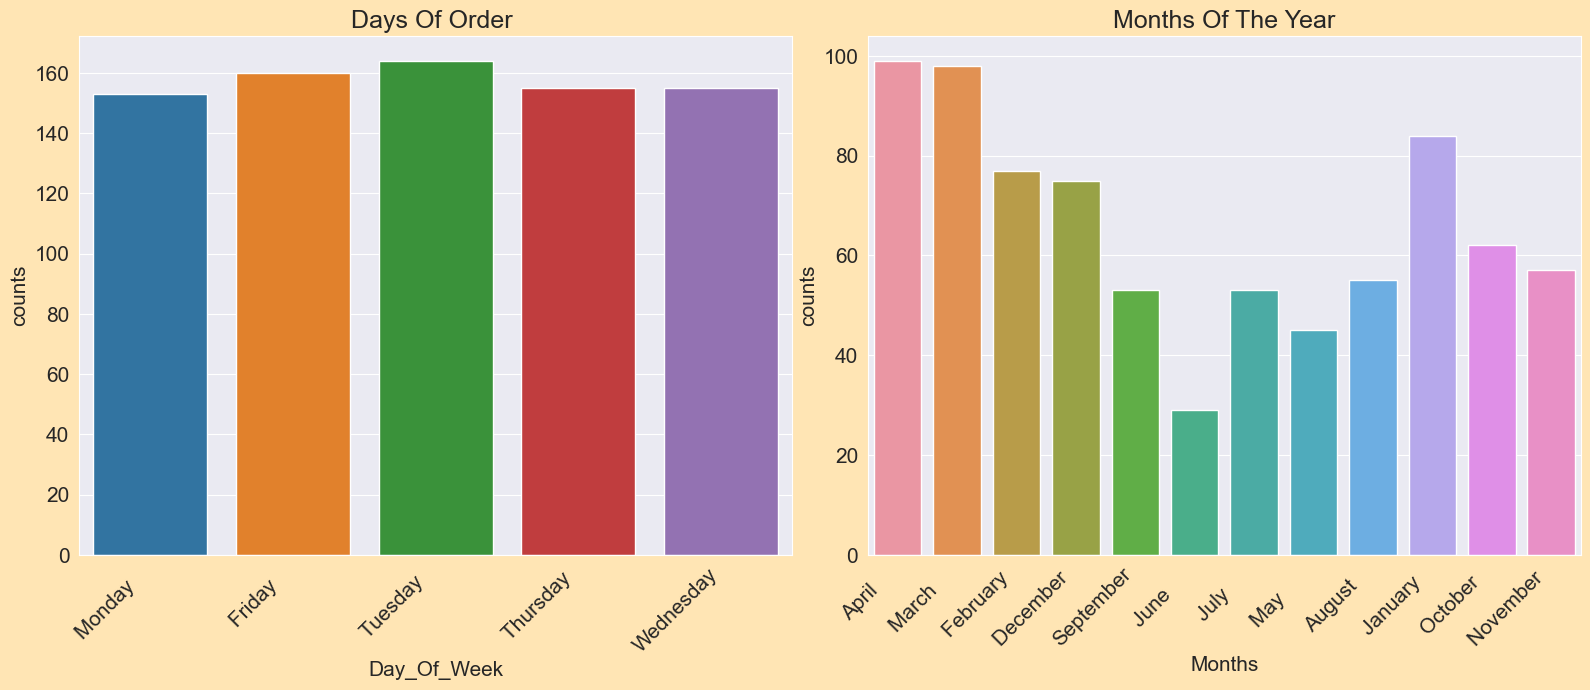

In [56]:
fig,axes = plt.subplots(1,2, figsize=(16,6))
plt.tight_layout()
xlabels = Days_Months.Day_Of_Week
axes[0].set_title("Days Of Order ")
axes[0].set_xticklabels(xlabels, rotation=45, ha = 'right')
sns.countplot(x = 'Day_Of_Week', data = Days_Months, ax=axes[0])
axes[0].set_ylabel('Counts')
axes[0].set_ylabel('counts')

xlabels = Days_Months.Months
axes[1].set_title("Months Of The Year")
axes[1].set_xticklabels(xlabels, rotation=45, ha = 'right')
sns.countplot(x = 'Months', data = Days_Months, ax=axes[1])
axes[1].set_ylabel('Counts')
axes[1].set_ylabel('counts');

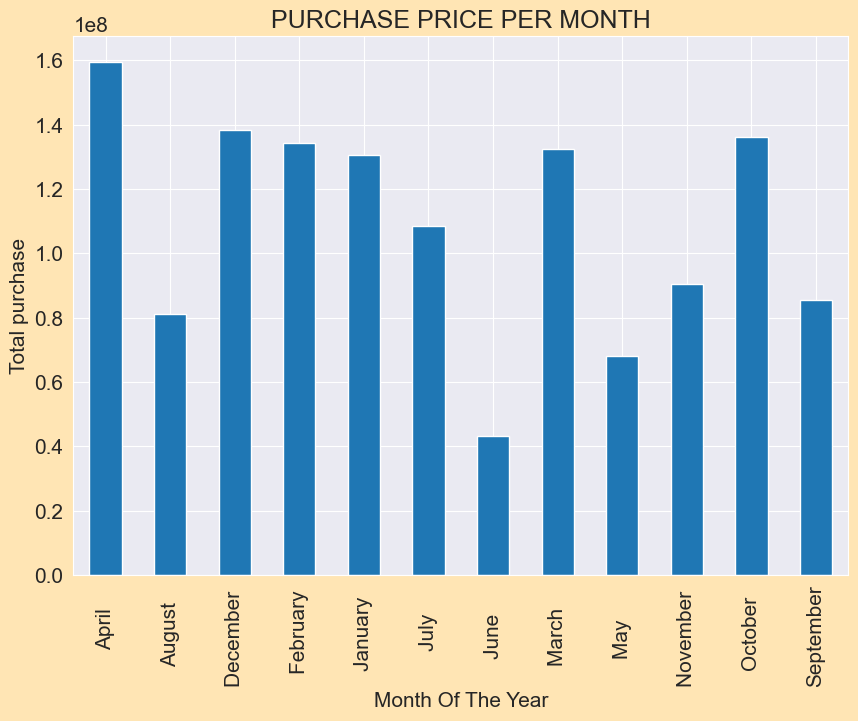

In [25]:
quantities_per_month = CLUSTER_DF.groupby("Months")["purchase_price"].sum()
quantities_per_month.plot(kind="bar")
plt.xlabel("Month Of The Year")
plt.ylabel("Total purchase")
plt.title("PURCHASE PRICE PER MONTH")
plt.show()

In [26]:
# Calculate average purchase price per Day_Of_Week
average_price_per_Day_Of_Week = CLUSTER_DF.groupby("Day_Of_Week")["purchase_price"].mean()
average_price_per_Day_Of_Week

Day_Of_Week
Friday       1412.754613
Monday       1542.627087
Thursday     1415.870746
Tuesday      1456.547662
Wednesday    1383.707274
Name: purchase_price, dtype: float64

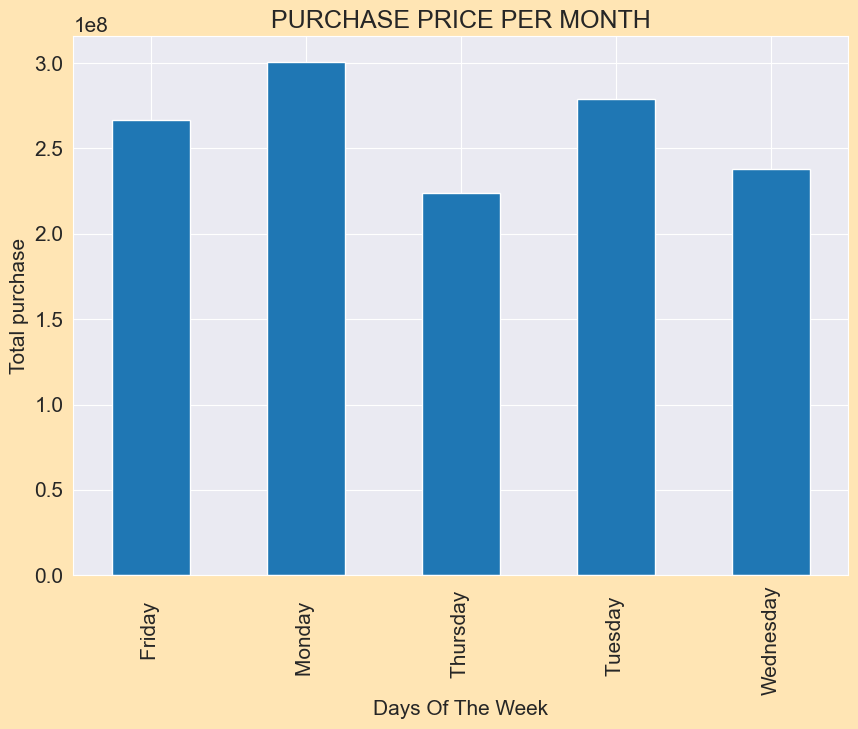

In [60]:
purchase_per_day= CLUSTER_DF.groupby("Day_Of_Week")["purchase_price"].sum()
purchase_per_day.plot(kind="bar")
plt.xlabel("Days Of The Week")
plt.ylabel("Total purchase")
plt.title("PURCHASE PRICE PER MONTH")
plt.show()

In [27]:
# Calculate average Quantities per Day_Of_Week
average_Quantities_Day_Of_Week = CLUSTER_DF.groupby("Day_Of_Week")["Quantities"].mean()
average_Quantities_Day_Of_Week

Day_Of_Week
Friday       55.828877
Monday       59.556984
Thursday     55.076827
Tuesday      54.827758
Wednesday    52.282967
Name: Quantities, dtype: float64

In [28]:
# Calculate average quantities per month
average_Quantities_month = CLUSTER_DF.groupby("Months")["Quantities"].mean()
average_Quantities_month

Months
April        57.283312
August       51.492997
December     58.442652
February     54.783154
January      54.356871
July         61.284109
June         51.360243
March        52.320958
May          50.543192
November     54.731336
October      60.063554
September    55.346705
Name: Quantities, dtype: float64

In [29]:
# Calculate average purchase price per year
average_price_per_Year = CLUSTER_DF.groupby("Year")["purchase_price"].mean()
average_price_per_Year

Year
1996    1427.848636
1997    1449.005933
1998    1448.994063
Name: purchase_price, dtype: float64

In [30]:
# Calculate average Quantities per year
average_Quantities_per_Year = CLUSTER_DF.groupby("Year")["Quantities"].mean()
average_Quantities_per_Year

Year
1996    54.102404
1997    55.979024
1998    55.948936
Name: Quantities, dtype: float64

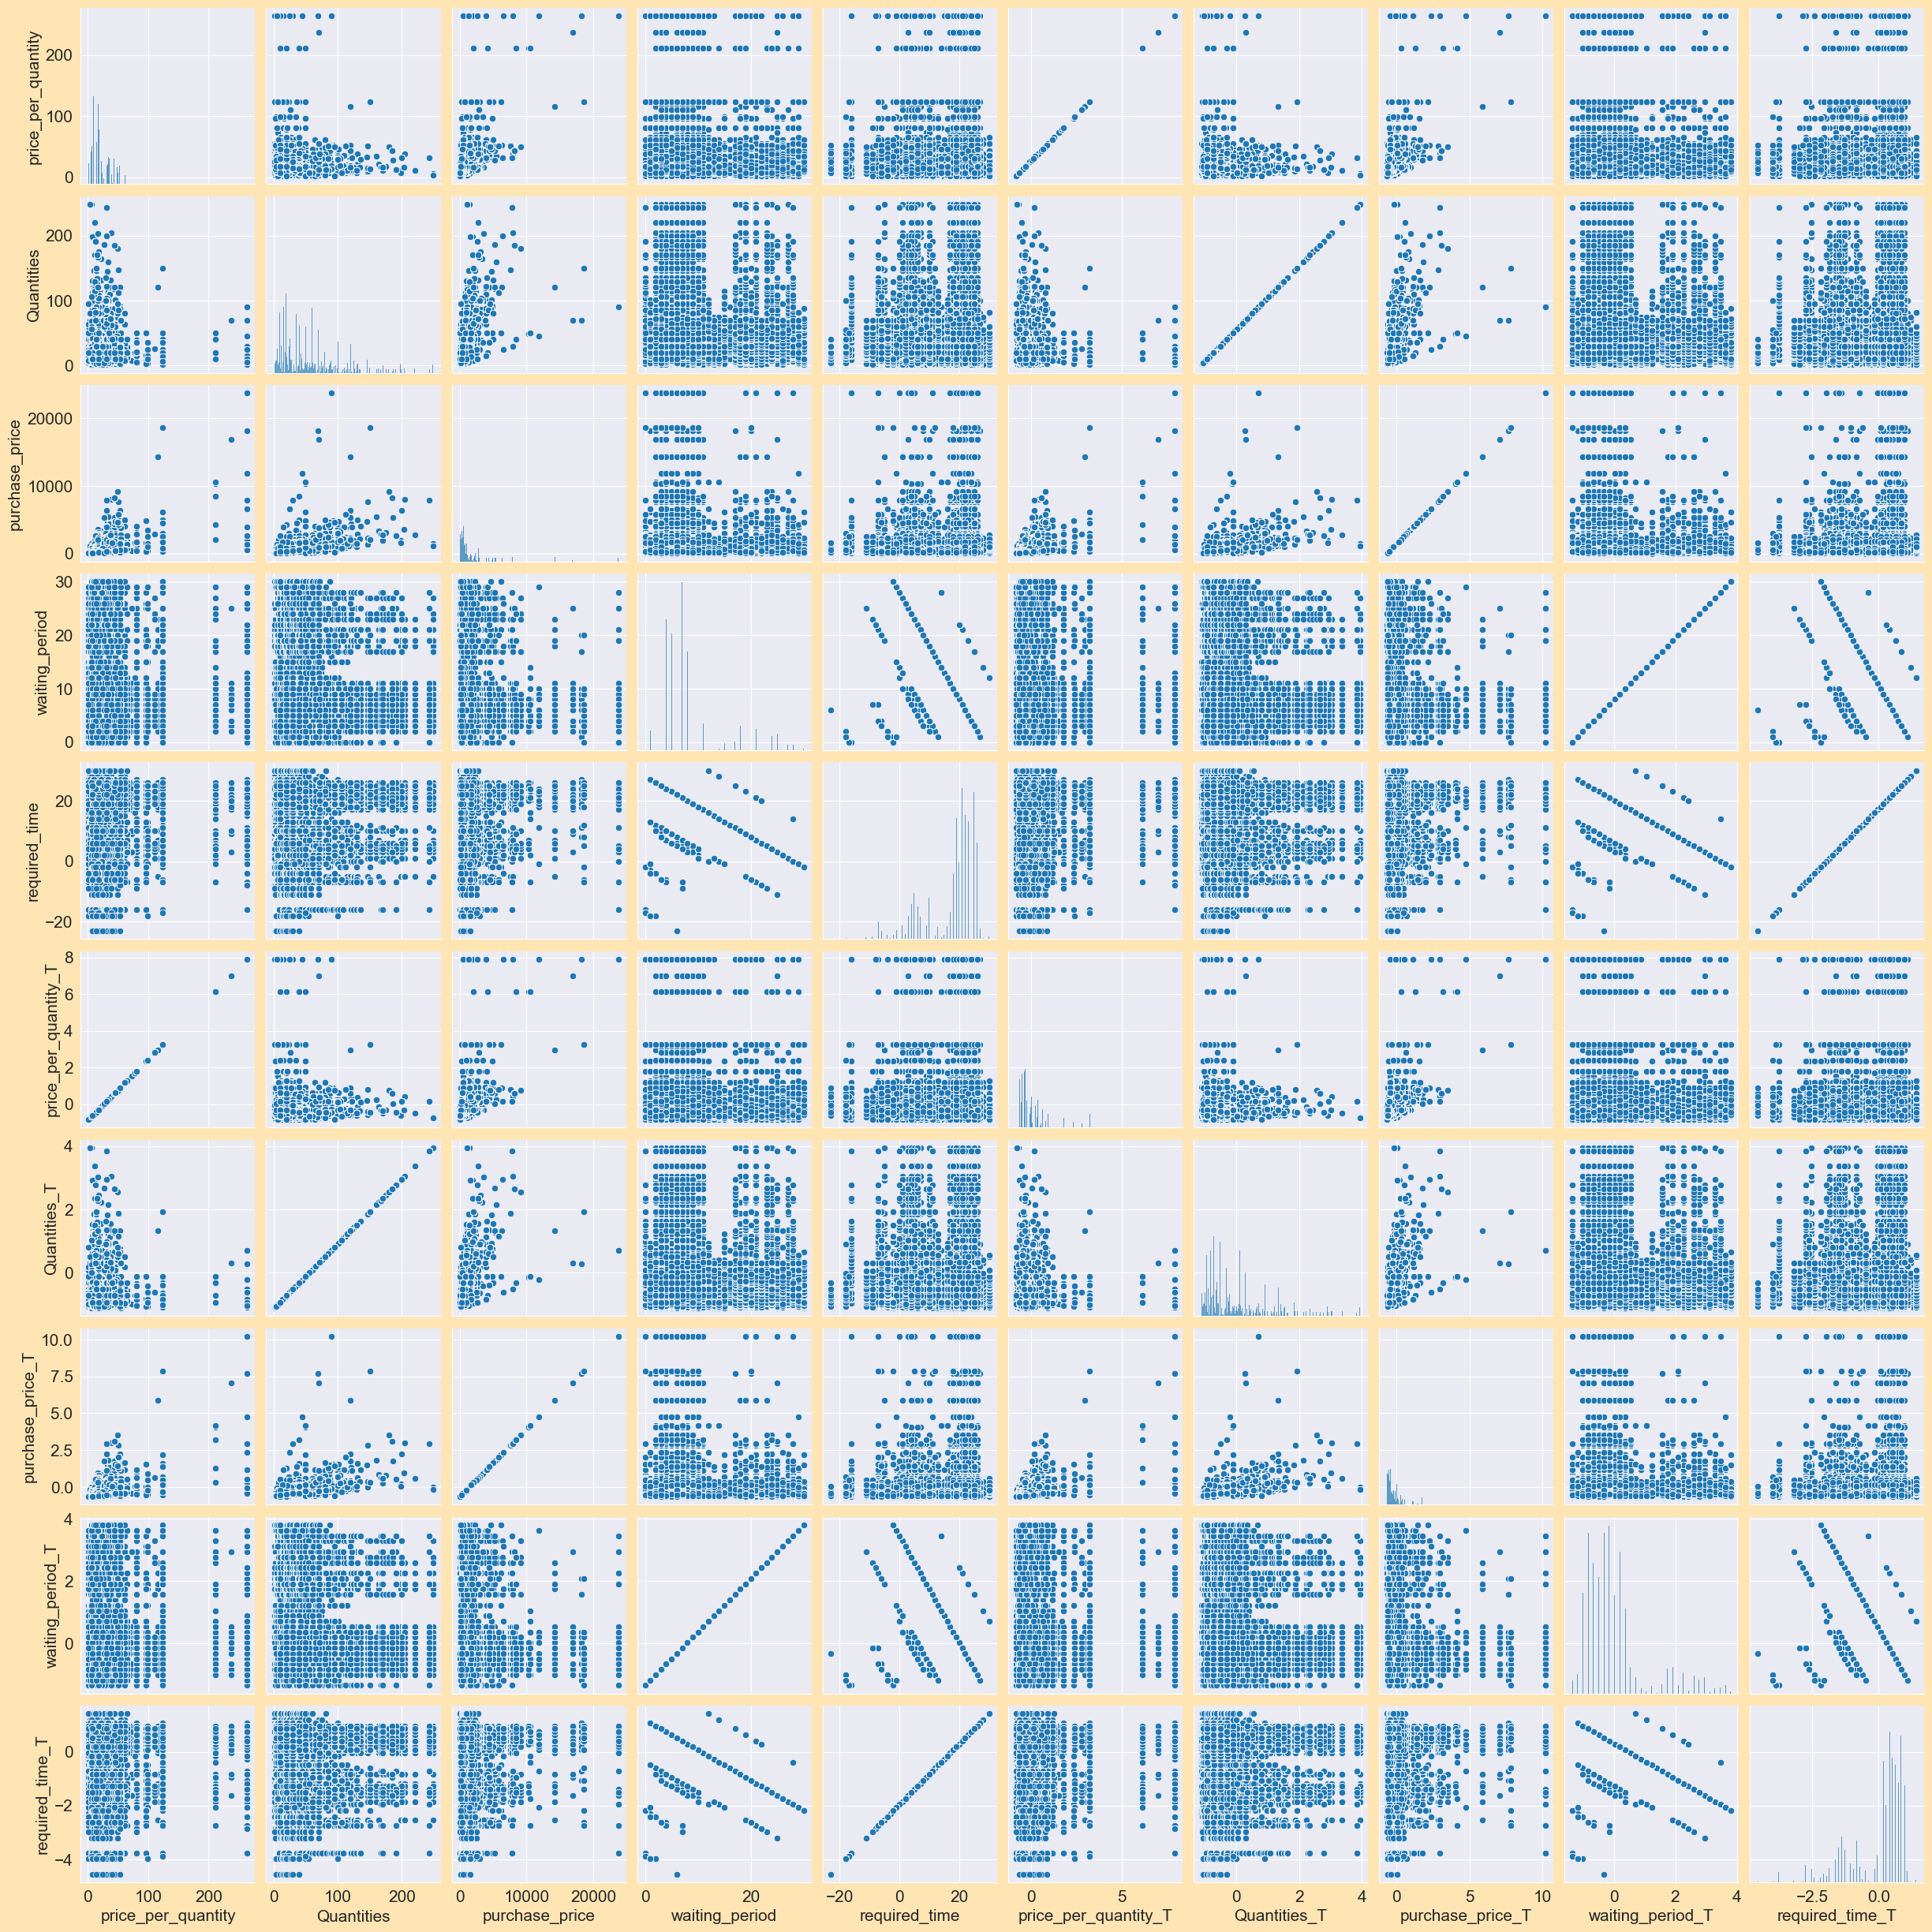

In [63]:
sns.pairplot(CLUSTER_DF)

In [31]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [32]:
scaler = StandardScaler()

In [33]:
## we then fit the standard scalar to the data and then transform our data using that scalar
CLUSTER_DF[[ 'price_per_quantity_T','Quantities_T', 'purchase_price_T', 'waiting_period_T', 'required_time_T']] = scaler.fit_transform(CLUSTER_DF[[ 'price_per_quantity','Quantities', 'purchase_price', 'waiting_period', 'required_time']] )

In [34]:
CLUSTER_DF.head()

,Day_Of_Week,Months,Year,customer_id,country_x,price_per_quantity,product_name,Quantities,purchase_price,waiting_period,required_time,price_per_quantity_T,Quantities_T,purchase_price_T,waiting_period_T,required_time_T
0,Monday,April,1998,HANAR,Brazil,22.0,Flotemysost,9,193.5,4.0,24.0,-0.158137,-0.955367,-0.574048,-0.659902,0.740337
1,Monday,April,1998,HANAR,Brazil,22.0,Flotemysost,9,193.5,4.0,24.0,-0.158137,-0.955367,-0.574048,-0.659902,0.740337
2,Monday,April,1998,HANAR,Brazil,22.0,Flotemysost,9,193.5,4.0,24.0,-0.158137,-0.955367,-0.574048,-0.659902,0.740337
3,Monday,April,1998,HANAR,Brazil,22.0,Flotemysost,9,193.5,6.0,8.0,-0.158137,-0.955367,-0.574048,-0.316369,-1.059646
4,Monday,April,1998,HANAR,Brazil,22.0,Flotemysost,9,193.5,6.0,8.0,-0.158137,-0.955367,-0.574048,-0.316369,-1.059646


In [35]:
# Select the features for clustering
features = ["Day_Of_Week", "Months", "Year", "purchase_price", "Quantities"]

In [36]:
# Create a new DataFrame with the selected features
cluster_data = CLUSTER_DF[features]

In [37]:
# Perform one-hot encoding for categorical variables (Day_Of_Week, Months)
cluster_data_encoded = pd.get_dummies(cluster_data)
cluster_data_encoded

,purchase_price,Quantities,Day_Of_Week_Friday,Day_Of_Week_Monday,Day_Of_Week_Thursday,Day_Of_Week_Tuesday,Day_Of_Week_Wednesday,Months_April,Months_August,Months_December,...,Months_July,Months_June,Months_March,Months_May,Months_November,Months_October,Months_September,Year_1996,Year_1997,Year_1998
0,193.5,9,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
1,193.5,9,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,193.5,9,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
3,193.5,9,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
4,193.5,9,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946386,77.5,10,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
946387,310.0,10,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
946388,310.0,10,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
946389,310.0,10,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


In [38]:
# Perform the elbow method to find the optimal value for k
max_k = 10  # Maximum number of clusters to consider
distortions = []
for k in range(1, max_k+1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(cluster_data_encoded)
    distortions.append(kmeans.inertia_)

C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_k

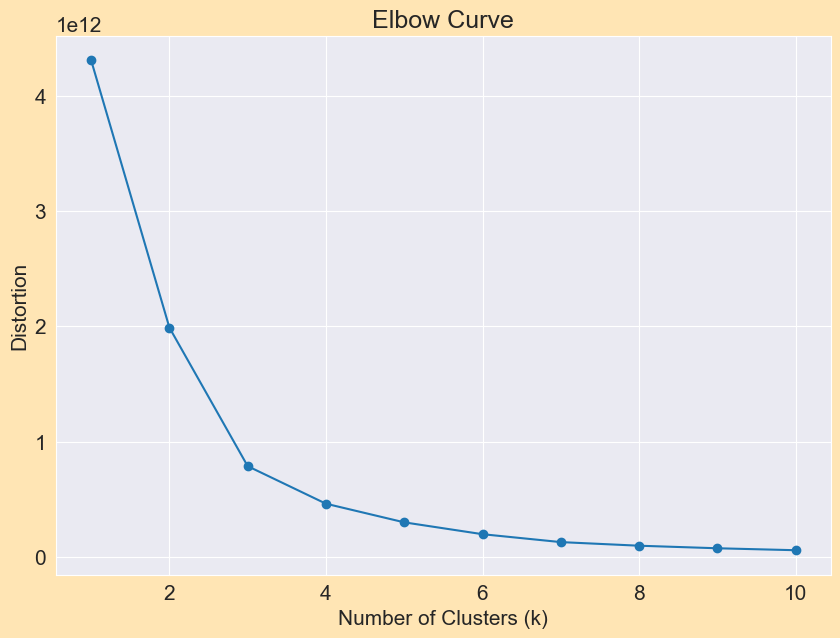

In [39]:
# Plot the elbow curve
plt.plot(range(1, max_k+1), distortions, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Distortion')
plt.title('Elbow Curve')
plt.show()

In [40]:
# Apply K-means clustering
k = 3  # Number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(cluster_data_encoded)

C:\Users\user\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=3, random_state=42)

In [41]:
# Get the cluster labels for each data point
cluster_labels = kmeans.labels_

In [42]:
# Add the cluster labels to the original DataFrame
cluster_data_encoded["Cluster"] = cluster_labels


In [43]:
# Calculate the average purchase price per cluster
average_price_per_cluster = cluster_data_encoded.groupby("Cluster")["purchase_price"].mean()


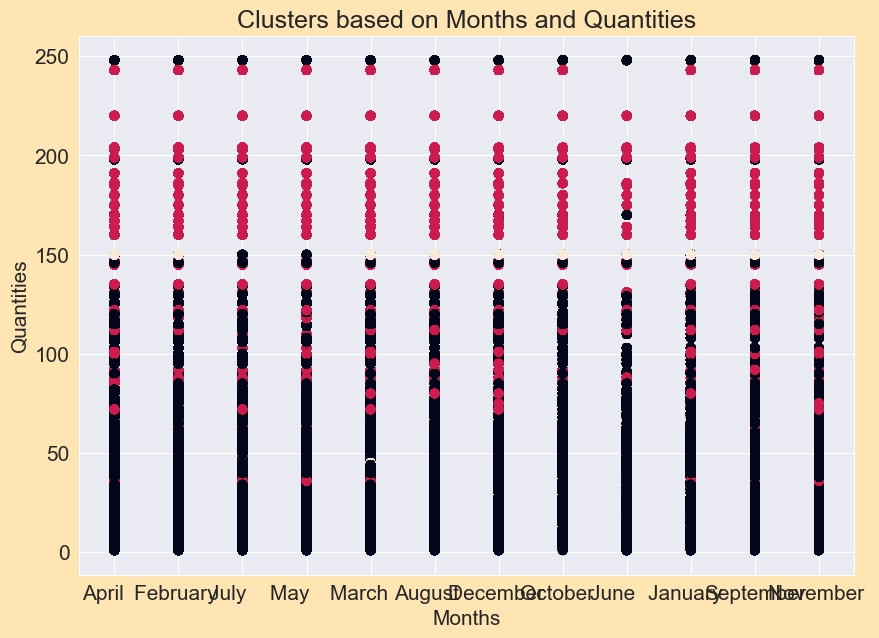

In [52]:
# Visualize the clusters on a scatter plot
plt.scatter(CLUSTER_DF["Months"], CLUSTER_DF["Quantities"], c=cluster_data_encoded["Cluster"])
plt.xlabel("Months")
plt.ylabel("Quantities")
plt.title("Clusters based on Months and Quantities")
plt.show()


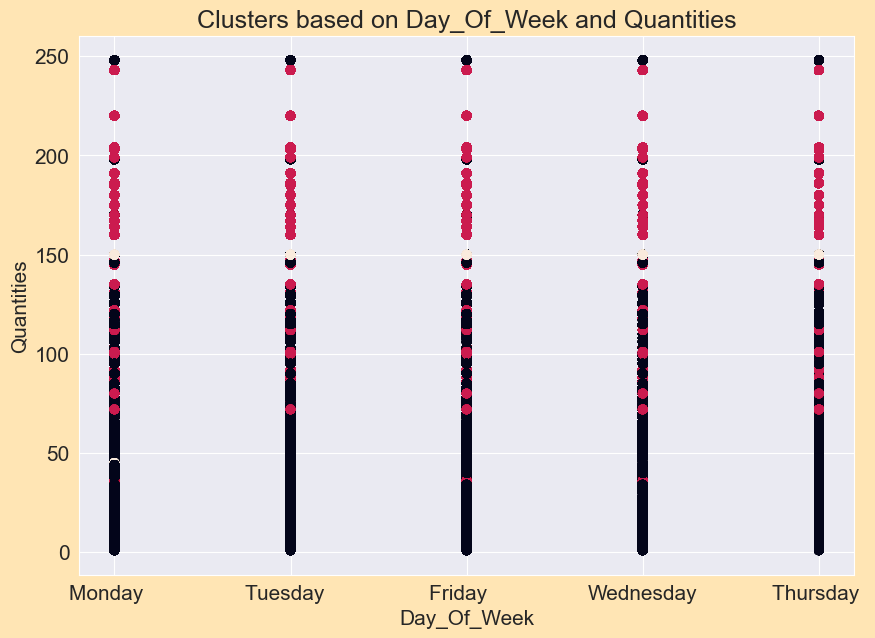

In [53]:
# Visualize the clusters on a scatter plot
plt.scatter(CLUSTER_DF["Day_Of_Week"], CLUSTER_DF["Quantities"], c=cluster_data_encoded["Cluster"])
plt.xlabel("Day_Of_Week")
plt.ylabel("Quantities")
plt.title("Clusters based on Day_Of_Week and Quantities")
plt.show()